In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import sys
sys.path.append('/content/gdrive/My Drive/workspace')

%cd 'gdrive/My Drive/workspace'

Mounted at /content/gdrive
/content/gdrive/My Drive/workspace


In [0]:
from PIL import Image

import numpy as np

from collections import Counter

from os.path import join
from os import listdir

from FaceRecognizer import FaceRecognizer

from scipy.spatial import distance
from scipy.optimize import brentq
from scipy.interpolate import interp1d

import dlib

from helpers import read_folds

from evaluation import plot_roc_curve, plot_score_distribution

from preprocessing import face_closeup

from matplotlib import pyplot as plt

import pandas as pd

from keras.models import load_model

from keras import backend as K

from importlib import reload

import preprocessing as prep

import json

from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, Cropping2D


Using TensorFlow backend.


In [0]:
predictor_path = 'shape_predictor_68_face_landmarks.dat'
detector_path = 'mmod_human_face_detector.dat'
root_path = 'lfw'

genuines_imposters_path = 'g_i_538_684.json'
path_to_weights = 'vgg_face_weights.h5'

# predictor_path = 'gdrive/My Drive/frworkspace/shape_predictor_68_face_landmarks.dat'
# detector_path = 'gdrive/My Drive/frworkspace/mmod_human_face_detector.dat'
# root_path = 'gdrive/My Drive/lfw/lfw'

# genuines_imposters_path = 'gdrive/My Drive/lfw/g_i_538_684.json'
# path_to_weights = 'gdrive/My Drive/vgg_face_weights.h5'

In [0]:


with open(genuines_imposters_path, 'r') as f:
    g, i  = json.load(f)

def f(names):
    name1 = names[0].rsplit('_',1)[0]
    name2 = names[1].rsplit('_',1)[0]
    path1 = root_path + '/' + name1 + '/'+ names[0]
    path2 = root_path + '/' + name2 + '/'+ names[1]
    return path1, path2, name1, name2
s = list(map(f, g))
d = list(map(f, i))


# pairs_path = 'gdrive/My Drive/lfw/pairs.txt'
# s,d = read_folds(1, pairs_path, root_path)

In [0]:

def mdistance(image1, image2, distance_function=distance.cosine):
    img1_representation = face_descriptor.predict(image1)[0,:]
    img2_representation = face_descriptor.predict(image2)[0,:]
    return distance_function(img1_representation, img2_representation)

In [0]:
vgg = FaceRecognizer()
vgg_model = vgg.get_vgg_model()

for layer in vgg_model.layers:
    layer.trainable=False

vgg_model.layers[-3].trainable=True
vgg_model.load_weights(path_to_weights)

face_descriptor = Model(inputs=vgg_model.get_input_at(0), outputs=vgg_model.layers[-2].output)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:

# # path_to_weights = 'gdrive/My Drive/vgg_face_weights.h5'

# vgg = FaceRecognizer()
# vgg_model = vgg.get_vgg_model()

# new_model = Sequential()
# for layer in vgg_model.layers[:-2]:
#     new_model.add(layer)

# new_model.add(Dense(1000,name='feature_reduction_dense'))
# new_model.add(Reshape((1000,),name='last_flatened_layer'))

# # # new_model.add(Dense(2622,name='last_dense_layer'))
# # new_model.add(Reshape((2622,),name='last_flatened_layer'))
# # new_model.add(Activation('softmax'))

# # new_model.load_weights('gdrive/My Drive/new_dense_added.h5')
# new_model.load_weights('gdrive/My Drive/tweak_last_layer.h5')

# face_descriptor = Model(inputs=new_model.get_input_at(0), outputs=new_model.layers[-1].output)


In [0]:
face_descriptor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1_input (Inpu (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 64)      0         
__________

In [0]:
cnn_face_detector = dlib.cnn_face_detection_model_v1(detector_path)

sp = dlib.shape_predictor(predictor_path)

In [0]:

trues = []
falses = []
for path1, path2, name1, name2 in s+d:
    img1 = dlib.load_rgb_image(path1)
    img2 = dlib.load_rgb_image(path2)
    
    
    img1 = prep.cropped_and_aligned(img1, cnn_face_detector, sp,method='cnn',size=224)
    img2 = prep.cropped_and_aligned(img2, cnn_face_detector, sp,method='cnn',size=224)
    
    
    img1 = vgg.preprocess_image(img1)
    img2 = vgg.preprocess_image(img2)
    dist = mdistance(img1, img2, distance_function=distance.cosine)

    if name1==name2:
        trues.append(1-dist)
    else:
        falses.append(1-dist)
labels = [1]*len(trues) + [0]*len(falses)
similarities = trues + falses

/content/gdrive/My Drive/frworkspace/preprocessing.py:99: UserWarning: Found 2 faces, using the one with the highest confidence score.
  warn('Found {} faces, using the one with the highest confidence score.'.format(len(dets)))
/content/gdrive/My Drive/frworkspace/preprocessing.py:99: UserWarning: Found 3 faces, using the one with the highest confidence score.
  warn('Found {} faces, using the one with the highest confidence score.'.format(len(dets)))


In [0]:
# margin=50
sum(trues)/len(trues),sum(falses)/len(falses)

(0.767871149521335, 0.45707633242141976)

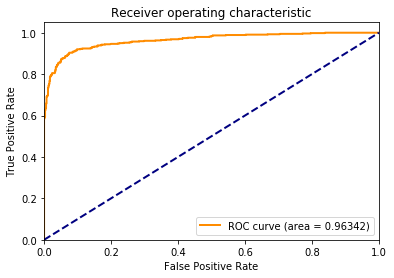

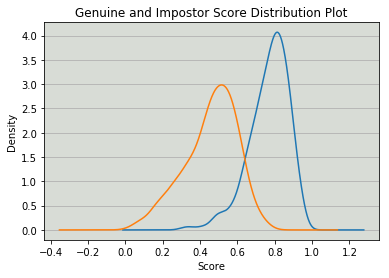

eer: 0.08968219416630381, thresh: 0.6254146361174561


In [0]:
fpr, tpr, thresholds = plot_roc_curve(labels, similarities)

plot_score_distribution(trues, falses)

eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, thresholds)(eer)
print('eer: {}, thresh: {}'.format(eer, thresh))

In [0]:
len(s),len(d)

(538, 683)